In [162]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv
from keras.models import model_from_json

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['test', 'sample_submission.csv', 'train.csv']


In [163]:
import random
import sys
import io
import os
import glob
import IPython
import matplotlib.pyplot as plt
import gc
import keras
from keras.callbacks import ModelCheckpoint
from keras.models import Model, load_model, Sequential
from keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D, Conv2D, Conv3D
from keras.layers import GRU, Bidirectional, BatchNormalization, Reshape
from keras.optimizers import Adam

In [164]:
sample_data=True
sample_per=100

In [165]:
#this one is high def data

#%%time
rowcount = 1000000000
    
if(not sample_data):
    #kernel supports >6m <60m 
    train = pd.read_csv("../input/train.csv", nrows=rowcount) 
    train.rename({"acoustic_data": "acd", "time_to_failure": "ttf"}, axis="columns", inplace=True)

    acd=train['acd']
    ttf=train['ttf']


if(sample_data):
    train = pd.read_csv('../input/train.csv', dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32})
    train.rename({"acoustic_data": "acd", "time_to_failure": "ttf"}, axis="columns", inplace=True)
    acd_small = train['acd'].values[::sample_per]
    ttf_small = train['ttf'].values[::sample_per]
    acd=acd_small
    ttf=ttf_small
    
    rowcount=int(train.shape[0]/sample_per)
    
#CHANGE THIS TO ROW BY ROW READING, TO GET ALL THE DATA AT ONCE. USE PYTHON READ CSV
#https://docs.python.org/2/library/csv.html

In [166]:
print(rowcount," ",train["acd"].size," ",train["ttf"].size)

6291454   629145480   629145480


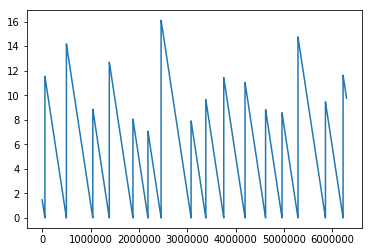

In [167]:
plt.plot(ttf)

In [168]:
def feature_generate(df,x,seg):

    for windows in [10, 100, 1000]:
        x_roll_std = x.rolling(windows).std().dropna().values
        df.loc[seg, '5q_roll_std' + str(windows)] = np.quantile(x_roll_std, 0.05)
        
    windows = 10
    x_roll_std = x.rolling(windows).std().dropna().values
    df.loc[seg, 'av_change_abs_roll_std' + str(windows)] = np.mean(np.diff(x_roll_std))
    
    windows = 100
    x_roll_mean = x.rolling(windows).mean().dropna().values
    df.loc[seg, 'std_roll_mean' + str(windows)] = x_roll_mean.std()
    
    return df

In [169]:
segments = int(np.floor(train.shape[0] / 150000))

In [170]:
X_train = pd.DataFrame(index=range(segments), dtype=np.float64)
y_train = pd.DataFrame(index=range(segments), dtype=np.float64, columns=['ttf'])

In [171]:
for s in range(segments):
    seg = train.iloc[s*150000:s*150000+150000]
    x = pd.Series(seg['acd'].values)
    y = seg['ttf'].values[-1]
    y_train.loc[s, 'ttf'] = y
    X_train = feature_generate(X_train,x,s)
columns=X_train.columns  
del train
gc.collect()
X_train["5q_roll_std10"].size

4194

In [172]:
X_train.shape

(4194, 5)

In [173]:
X_train.rename({"5q_roll_std10": "std10", "5q_roll_std100": "std100", "5q_roll_std1000": "std1000", "av_change_abs_roll_std10": "avabsmean10", "std_roll_mean100": "stdmean100"}, axis="columns", inplace=True)

std10=X_train['std10']
std100=X_train['std100']
std1000=X_train['std1000']
avabsmean10=X_train['avabsmean10']
stdmean100=X_train['stdmean100']

print(X_train.size, y_train.size)

20970 4194


In [251]:
# GRADED FUNCTION: model

def model(input_shape):
    """
    Function creating the model's graph in Keras.
    
    Argument:
    input_shape -- shape of the model's input data (using Keras conventions)

    Returns:
    model -- Keras model instance
    """
    
    X_input = Input(shape = input_shape)
    
    ### START CODE HERE ###
    
    # Step 1: CONV layer (≈4 lines)
    X = Conv1D(196, kernel_size=1, strides=1)(X_input)                                 # CONV1D
    X = BatchNormalization()(X)                                 # Batch normalization
    X = Activation('relu')(X)                                 # ReLu activation
    X = Dropout(0.8)(X)                                 # dropout (use 0.8)

    # Step 2: First GRU Layer (≈4 lines)
    X = GRU(units = 128, return_sequences = True)(X) # GRU (use 128 units and return the sequences)
    X = Dropout(0.8)(X)                                 # dropout (use 0.8)
    X = BatchNormalization()(X)                                 # Batch normalization
    
    # Step 3: Second GRU Layer (≈4 lines)
    X = GRU(units = 128, return_sequences = True)(X)   # GRU (use 128 units and return the sequences)
    X = Dropout(0.8)(X)                                 # dropout (use 0.8)
    X = BatchNormalization()(X)                                  # Batch normalization
    X = Dropout(0.8)(X)                                  # dropout (use 0.8)
    
    # Step 4: Time-distributed dense layer (≈1 line)
    X = TimeDistributed(Dense(1, activation = "relu"))(X) # time distributed
    #X = TimeDistributed(Dense(1),activation="sigmoid")(X) # time distributed  (sigmoid)
    
    
    ### END CODE HERE ###

    model = Model(inputs = X_input, outputs = X)
    
    return model

#sauce: https://github.com/Gurupradeep/deeplearning.ai-Assignments/blob/master/Sequence%20Models/Week3/Trigger%2Bword%2Bdetection%2B-%2Bv1.ipynb

(9, 4179)


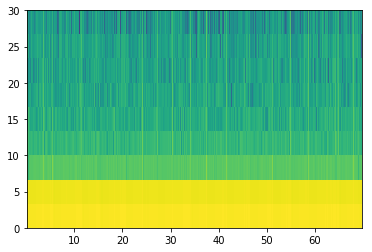

In [252]:
#prepare x
nfft = 16 # Length of each window segment
fs = 60 # Sampling frequencies
noverlap = 15 # Overlap between windows
std10_pxx, freqs, bins, im = plt.specgram(std10[:rowcount], nfft, fs, noverlap = noverlap)

samplecount_x=std10_pxx[0].shape[0]
print(std10_pxx.shape)

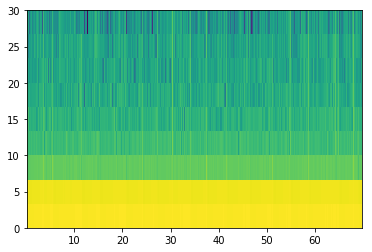

In [253]:
std100_pxx, freqs, bins, im = plt.specgram(std100[:rowcount], nfft, fs, noverlap = noverlap)

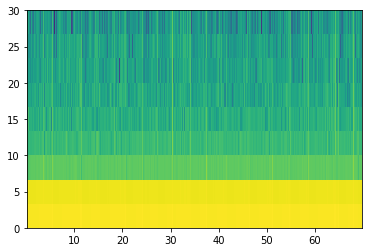

In [254]:
std1000_pxx, freqs, bins, im = plt.specgram(std1000[:rowcount], nfft, fs, noverlap = noverlap)

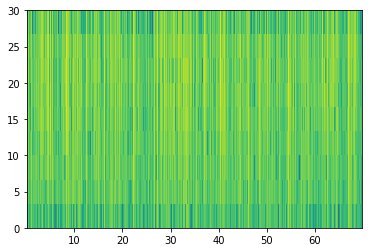

In [255]:
avabsmean10_pxx, freqs, bins, im = plt.specgram(avabsmean10[:rowcount], nfft, fs, noverlap = noverlap)

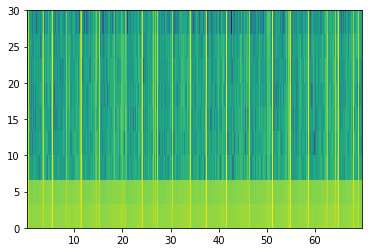

In [256]:
stdmean100_pxx, freqs, bins, im = plt.specgram(stdmean100[:rowcount], nfft, fs, noverlap = noverlap)

In [257]:
numof_features=3
n_freq = std10_pxx.shape[0]*numof_features
model = model(input_shape = (samplecount_x, n_freq))

opt = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, decay=0.01)
model.compile(loss='mse', optimizer=opt, metrics=["mae"])

In [258]:
avabsmean10_pxx = np.array(avabsmean10_pxx) * 10000000000
std10_pxx[3:] *= 10000
#std10_pxx       = np.array(std10_pxx) * 10000


In [259]:
std10_pxx = std10_pxx.swapaxes(0,1)
avabsmean10_pxx = avabsmean10_pxx.swapaxes(0,1)
stdmean100_pxx = stdmean100_pxx.swapaxes(0,1)
#numof_features * feature
#x = np.hstack((std10_pxx, avabsmean10_pxx, stdmean100_pxx))
x = np.hstack((std10_pxx, stdmean100_pxx, avabsmean10_pxx))
#u = np.reshape(x,(x.shape[1],x.shape[2]))
#x=x.swapaxes(0,1)
u=x
x = np.expand_dims(x, axis=0)
print(u.shape)


(4179, 27)


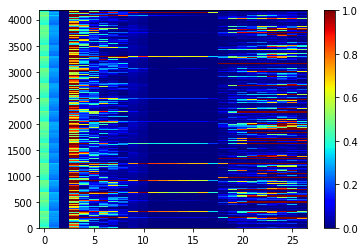

In [260]:
plt.imshow(u, cmap='jet',
           vmin=0, vmax=1, origin='lowest', aspect='auto')
plt.colorbar()
plt.show()

1506
4179   (4194, 1)   1506   (4194, 5)   (4179, 1)


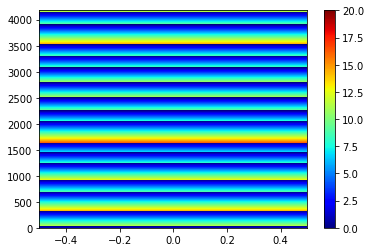

In [261]:
import math
samplecount_y= model.predict(x).shape[1]
sampler = int(math.ceil(rowcount/samplecount_y))
print(sampler)
y_u = np.resize(y_train, (samplecount_y,1))                                                        #ONLY APPLY IF samplecount_y ~ y_train.shape[1]
#y_u = y_train
print(samplecount_y , " " , y_train.shape, " ", sampler, " ", X_train.shape," ", y_u.shape)
plt.imshow(y_u, cmap='jet',
           vmin=0, vmax=20, origin='lowest', aspect='auto')
plt.colorbar()
plt.show()

In [262]:
y_u = np.expand_dims(y_u, axis=0)

In [263]:
c=0

In [265]:
#train
import time
timeout = time.time() + 1800
while True:
    c+=1
    model.fit(x,y_u, epochs=1)
    if(time.time()> timeout):
        print("{0} EPOCHS".format(c))
        break

Epoch 1/1
1/1 [==============================] - 5s 5s/step - loss: 22.4375 - mean_absolute_error: 3.6988
Epoch 1/1
1/1 [==============================] - 5s 5s/step - loss: 21.7960 - mean_absolute_error: 3.6534
Epoch 1/1


KeyboardInterrupt: 

In [ ]:
print("{0} EPOCHS".format(c))